# Feature Selection

## Notebook Setup

### Import Libraries

In [3]:
# Import Standard Libraries
import os
import datetime
import pickle
import itertools
import pandas as pd
import numpy as np

# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import shap

# Import custom functions
import env_functions as ef
import s3_functions as sf
import common_functions as cf

Loading dotenv file


In [15]:
# Import Modeling Libraries
import xgboost as xgb

# Import Evaluation Libraries
from sklearn import set_config
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Multicolinearity Imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [5]:
# Determine the environment and get appropriate vars
deepnote, env_vars = ef.load_env_vars()

# Iterate through the vars and set them as global vars
for var_name, var in env_vars.items():
    globals()[var_name] = var

# If not in the DeepNote environment, create a dict for aws creds
#   that were located in the environment file.  This will be passed
#   to all aws s3 functions.
if not deepnote:
    aws_env_vars = {
        'access_key_id': aws_access_key_id,
        'secret_access_key': aws_secret_access_key,
        'bucket_name': s3_bucket_name
    }

Loading dotenv file


In [17]:
# Pandas Configs
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Ignore Warnings
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

# MapBox Token for Plotly Maps
px.set_mapbox_access_token(os.environ.get("MAPBOX_TOKEN"))

# Scikit Learn Configs
set_config(transform_output="pandas")

### Import the Data

In [7]:
if deepnote:
    # GLOB Data
    X_train_GLOB = pd.read_parquet("/work/data/Xy_Data/X_train_GLOB.parquet")
    X_val_GLOB = pd.read_parquet("/work/data/Xy_Data/X_val_GLOB.parquet")
    X_holdout_GLOB = pd.read_parquet("/work/data/Xy_Data/X_holdout_GLOB.parquet")
    
    y_train_GLOB = pd.read_parquet("/work/data/Xy_Data/y_train_GLOB.parquet")
    y_val_GLOB = pd.read_parquet("/work/data/Xy_Data/y_val_GLOB.parquet")
    y_holdout_GLOB = pd.read_parquet("/work/data/Xy_Data/y_holdout_GLOB.parquet")
    
    # CARB Data
    X_train_CARB = pd.read_parquet("/work/data/Xy_Data/X_train_CARB.parquet")
    X_val_CARB = pd.read_parquet("/work/data/Xy_Data/X_val_CARB.parquet")
    X_holdout_CARB = pd.read_parquet("/work/data/Xy_Data/X_holdout_CARB.parquet")
    
    y_train_CARB = pd.read_parquet("/work/data/Xy_Data/y_train_CARB.parquet")
    y_val_CARB = pd.read_parquet("/work/data/Xy_Data/y_val_CARB.parquet")
    y_holdout_CARB = pd.read_parquet("/work/data/Xy_Data/y_holdout_CARB.parquet")
    
    # SEAA Data
    X_train_SEAA = pd.read_parquet("/work/data/Xy_Data/X_train_SEAA.parquet")
    X_val_SEAA = pd.read_parquet("/work/data/Xy_Data/X_val_SEAA.parquet")
    X_holdout_SEAA = pd.read_parquet("/work/data/Xy_Data/X_holdout_SEAA.parquet")
    
    y_train_SEAA = pd.read_parquet("/work/data/Xy_Data/y_train_SEAA.parquet")
    y_val_SEAA = pd.read_parquet("/work/data/Xy_Data/y_val_SEAA.parquet")
    y_holdout_SEAA = pd.read_parquet("/work/data/Xy_Data/y_holdout_SEAA.parquet")
else:
    # GLOB Data
    X_train_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_train_GLOB.parquet", **aws_env_vars))
    X_val_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_val_GLOB.parquet", **aws_env_vars))
    X_holdout_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_holdout_GLOB.parquet", **aws_env_vars))
    
    y_train_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_train_GLOB.parquet", **aws_env_vars))
    y_val_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_val_GLOB.parquet", **aws_env_vars))
    y_holdout_GLOB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_holdout_GLOB.parquet", **aws_env_vars))
    
    # CARB Data
    X_train_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_train_CARB.parquet", **aws_env_vars))
    X_val_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_val_CARB.parquet", **aws_env_vars))
    X_holdout_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_holdout_CARB.parquet", **aws_env_vars))
    
    y_train_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_train_CARB.parquet", **aws_env_vars))
    y_val_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_val_CARB.parquet", **aws_env_vars))
    y_holdout_CARB = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_holdout_CARB.parquet", **aws_env_vars))
    
    # SEAA Data
    X_train_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_train_SEAA.parquet", **aws_env_vars))
    X_val_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_val_SEAA.parquet", **aws_env_vars))
    X_holdout_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/X_holdout_SEAA.parquet", **aws_env_vars))
    
    y_train_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_train_SEAA.parquet", **aws_env_vars))
    y_val_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_val_SEAA.parquet", **aws_env_vars))
    y_holdout_SEAA = pd.read_parquet(sf.load_from_s3(file_path="data/Xy_Data/y_holdout_SEAA.parquet", **aws_env_vars))

In [9]:
drop_cols = ['Sample_ID', 'Site_ID', 'Reef_ID', 'Date_Day', 'Date_Month',
             'Date_Year', 'Ocean_Name','Realm_Name',
             'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name',
             'City_Town_Name_1', 'City_Town_Name_2', 'City_Town_Name_3',
             'City_Town_Name_4', 'Data_Source', 'Bleached_Value_Imputed', 'Date',
             'Month_Name', 'Month_Year', 'Country_Code', 'Exposure_Cat',
             'Country_Name_Cat', 'PROVINCE', 'Year', 'Exposure', 'Substrate_Name']

In [10]:
X_train_GLOB = X_train_GLOB.drop(columns=drop_cols)
X_val_GLOB = X_val_GLOB.drop(columns=drop_cols)
X_holdout_GLOB = X_holdout_GLOB.drop(columns=drop_cols)

X_train_CARB = X_train_CARB.drop(columns=drop_cols)
X_val_CARB = X_val_CARB.drop(columns=drop_cols)
X_holdout_CARB = X_holdout_CARB.drop(columns=drop_cols)

X_train_SEAA = X_train_SEAA.drop(columns=drop_cols)
X_val_SEAA = X_val_SEAA.drop(columns=drop_cols)
X_holdout_SEAA = X_holdout_SEAA.drop(columns=drop_cols)

# Build and Train Basic Model

In [11]:
model = cf.model_score(hps={}, model_type='xgb', val=True, Xtt=X_train_GLOB, ytt=y_train_GLOB, Xvt=X_val_GLOB, yvt=y_val_GLOB, Xht=X_holdout_GLOB, yht=y_holdout_GLOB)

 
Validation Mean Absolute Error: 9.2062
Validation Mean Squared Error: 239.4723
Validation Root Mean Squared Error: 15.4749
Validation R^2 Score: 0.4854


# Plot Feature Importance

In [14]:
cf.plot_feat_importance(model)

# Variance Inflation Factor

In [18]:
# VIF needs an intercept term in the model, so add a constant to X_train_trans
X_with_const = add_constant(X_train_GLOB)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(X_with_const.columns))]

# Print VIF for each feature in descending order, skipping the constant
print(vif_data[1:].sort_values(by='VIF', ascending=False))

                                  feature        VIF
50                         ER.FSH.PROD.MT 1207811.61
48                         ER.FSH.AQUA.MT  657392.33
28                 TSA_Standard_Deviation  169994.31
12  Temperature_Kelvin_Standard_Deviation  169179.33
9                        Temperature_Mean  160715.11
10                    Temperature_Minimum  136172.86
29                            TSA_Minimum  118038.76
49                         ER.FSH.CAPT.MT  112498.95
31                               TSA_Mean   79339.18
11                    Temperature_Maximum   56798.49
30                            TSA_Maximum   32399.47
8                      Temperature_Kelvin   12299.23
27                                    TSA    8508.06
37             TSA_DHW_Standard_Deviation     279.12
39                            TSA_DHWMean     237.21
26                           SSTA_DHWMean     167.13
24            SSTA_DHW_Standard_Deviation     106.66
51                         ER.MRN.PTMR.ZS     

Massive amount of multicollinearity, which will cause the model to perform suboptimally.  Next step is to reduce some of these features so that we can keep the highest amount of explainability while reducing the multicollinearity.  We'll remove all of the means and stddevs, along with min and max value sfor measurements.  We'll also move proxy values, such as population and its density, as well as remove extraneous WDI indicators, such as marine parks and tourism. We'll focus on fertilizers and fishing from the WDI dataset.

In [19]:
X_train_GLOB.columns

Index(['Depth_m', 'Latitude_Degrees', 'Longitude_Degrees', 'Distance_to_Shore',
       'Turbidity', 'Cyclone_Frequency', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'AG.CON.FERT.ZS', 'AG.LND.AGRI.K2',
       'AG.LND.AGRI.ZS', 'AG.LND.FRST.K2', 'AG.LND.FRST.ZS',
       'AG.LND.IRIG.AG.ZS', 'EN.FSH.THRD.NO', 'EN.POP.DNST', 'ER.FSH

In [20]:
keep_cols = [
    'Depth_m',
    'Distance_to_Shore',
    'Longitude_Degrees',
    'Turbidity',
    'Latitude_Degrees',
    'ClimSST',
    'Cyclone_Frequency',
    'SSTA_Frequency',
    'TSA_Frequency',
    'AG.LND.AGRI.K2', 'AG.CON.FERT.ZS',
    'EN.FSH.THRD.NO', 'ER.FSH.CAPT.MT',
    'SSTA','TSA','SSTA_DHW','TSA_DHW'
    ]  

In [21]:
X_train_trans_GLOB = X_train_GLOB[keep_cols]
X_val_trans_GLOB = X_val_GLOB[keep_cols]
X_holdout_trans_GLOB = X_holdout_GLOB[keep_cols]

X_train_trans_CARB = X_train_CARB[keep_cols]
X_val_trans_CARB = X_val_CARB[keep_cols]
X_holdout_trans_CARB = X_holdout_CARB[keep_cols]

X_train_trans_SEAA = X_train_SEAA[keep_cols]
X_val_trans_SEAA = X_val_SEAA[keep_cols]
X_holdout_trans_SEAA = X_holdout_SEAA[keep_cols]

# Build and Train New Model on Refined Columns

In [22]:
refined_model = cf.model_score(hps={}, model_type='xgb', val=True, Xtt=X_train_trans_GLOB, ytt=y_train_GLOB, Xvt=X_val_trans_GLOB, yvt=y_val_GLOB, Xht=X_holdout_trans_GLOB, yht=y_holdout_GLOB)

 
Validation Mean Absolute Error: 9.5270
Validation Mean Squared Error: 251.7355
Validation Root Mean Squared Error: 15.8662
Validation R^2 Score: 0.4590


In [29]:
print("Number of orginal features:", len(X_train_GLOB.columns))
print("Number of refined features:", len(X_train_trans_GLOB.columns))

Number of orginal features: 57
Number of refined features: 17


Our model score has dropped slightly, but we've simplified the model by 40 features.

## Feature Importance on New Model with Refined Columns

In [32]:
cf.plot_feat_importance(refined_model)

## Variance Inflation Factor on Refined Features

In [34]:
# VIF needs an intercept term in the model, so add a constant to X_train_trans
X_with_const = add_constant(X_train_trans_GLOB)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(X_with_const.columns))]

# Print VIF for each feature in descending order, skipping the constant
print(vif_data[1:].sort_values(by='VIF', ascending=False))

              feature  VIF
10     AG.LND.AGRI.K2 5.03
17            TSA_DHW 4.01
16           SSTA_DHW 3.79
12     EN.FSH.THRD.NO 3.60
9       TSA_Frequency 2.40
13     ER.FSH.CAPT.MT 2.18
8      SSTA_Frequency 2.13
5    Latitude_Degrees 2.12
3   Longitude_Degrees 1.86
15                TSA 1.65
14               SSTA 1.62
11     AG.CON.FERT.ZS 1.53
4           Turbidity 1.46
7   Cyclone_Frequency 1.22
2   Distance_to_Shore 1.14
1             Depth_m 1.13
6             ClimSST 1.06


All VIF scores are below 10, which is excellent from a multicollinearity perspective. Next step is SHAP analysis, to determine if there are any interesting interactions or features.

# SHAP Feature Analysis

In [35]:
%%time
explainer = shap.TreeExplainer(refined_model)
shap_values = explainer(X_val_trans_GLOB)
shap_interaction = explainer.shap_interaction_values(X_val_trans_GLOB)
sv = explainer.shap_values(X_val_trans_GLOB)
shap.initjs()

CPU times: total: 3min 25s
Wall time: 7.19 s


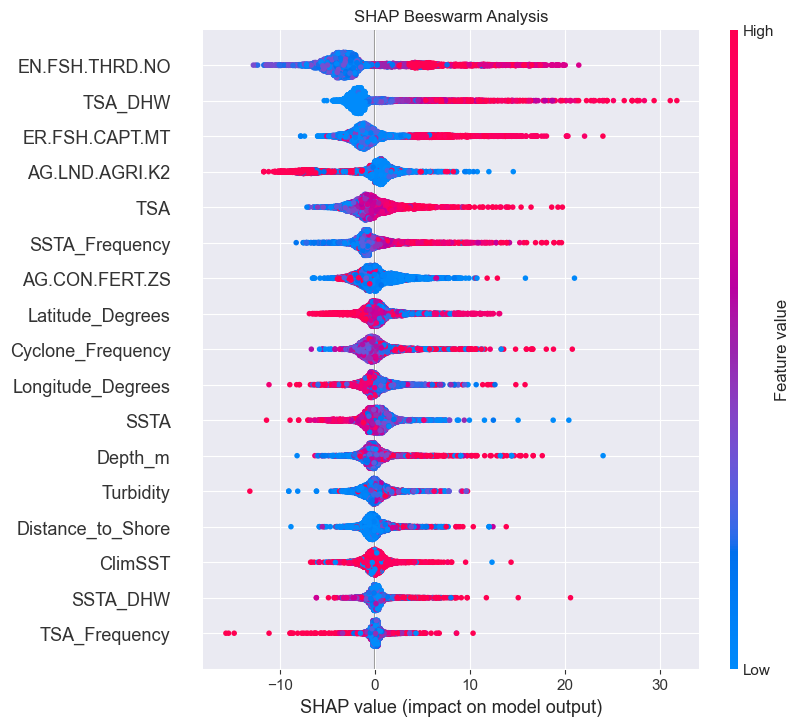

In [36]:
# Beeswarm Importance
plt.figure(figsize=(8,6))
plt.title(f"SHAP Beeswarm Analysis")
shap.plots.beeswarm(shap_values, max_display=32)
plt.close()

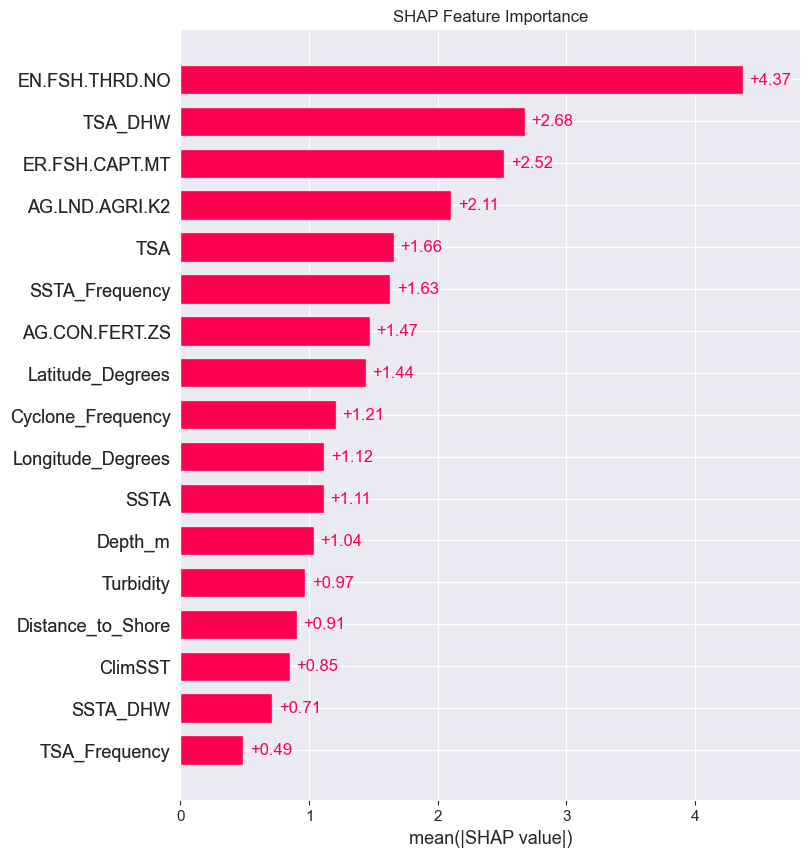

In [37]:
# Feature Importance
plt.figure(figsize=(6,4))
plt.title(f"SHAP Feature Importance")
shap.plots.bar(shap_values, max_display=20) # , show=False
#anno_text = f'Some Info Here'
#plt.annotate(anno_text, (0.5, -0.15), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
#plt.savefig("final_images/shap_feature_importance.png", bbox_inches='tight')
plt.close()

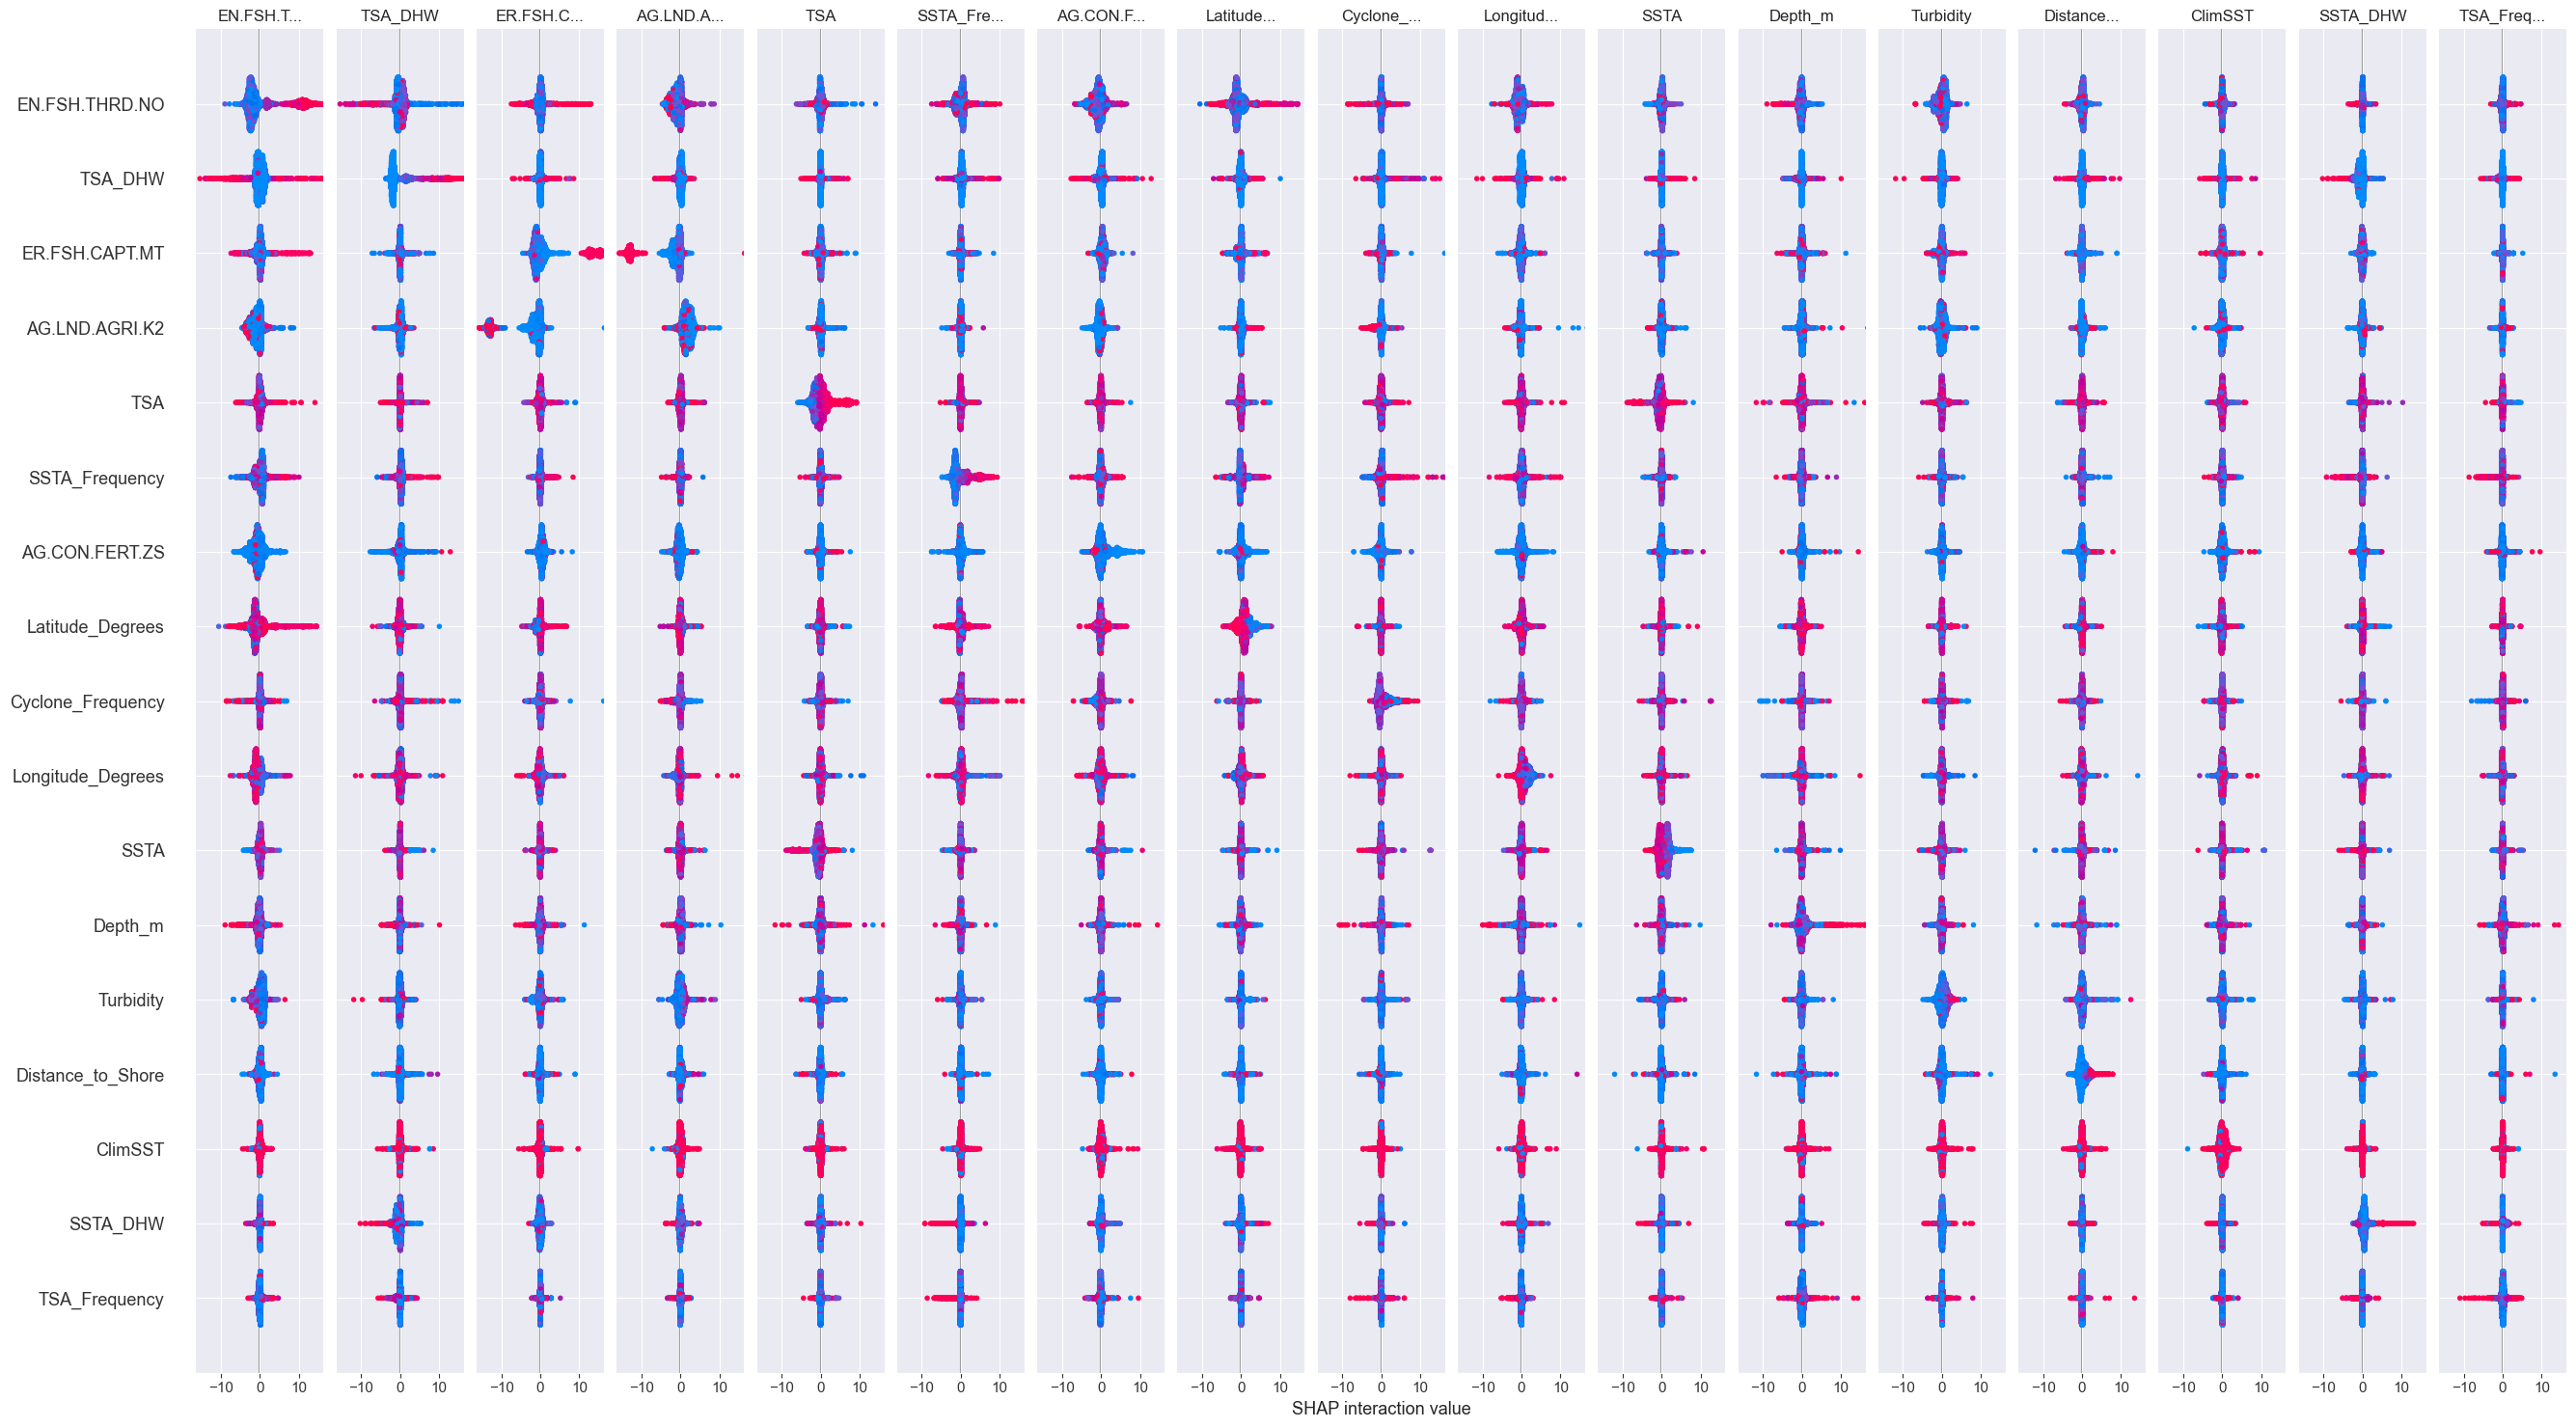

In [39]:
# Summary plot for dependencies
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html
shap.summary_plot(shap_interaction, X_val_trans_GLOB, max_display=20)

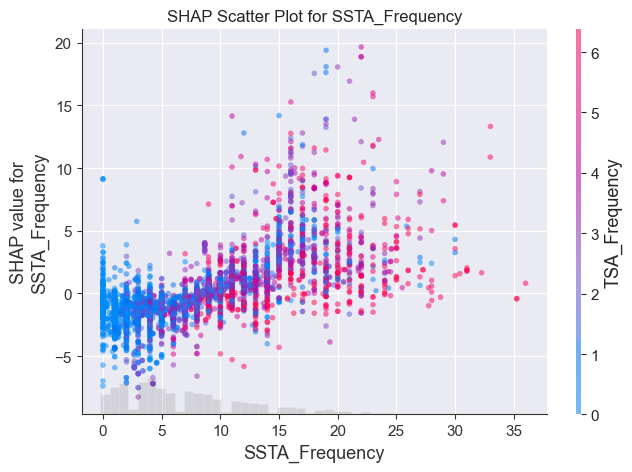

In [40]:
# Scatterplot
shap.plots.scatter(shap_values[:, "SSTA_Frequency"], color=shap_values[:, "TSA_Frequency"], alpha=0.5, x_jitter=1, show=False)
plt.title(f"SHAP Scatter Plot for SSTA_Frequency")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

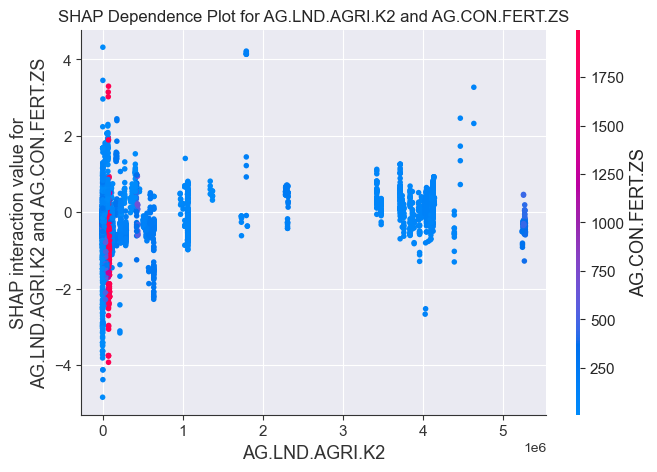

In [42]:
# Dependency plot
shap.dependence_plot(("AG.LND.AGRI.K2", "AG.CON.FERT.ZS"), shap_interaction, X_val_trans_GLOB, show=False)
plt.title(f"SHAP Dependence Plot for AG.LND.AGRI.K2 and AG.CON.FERT.ZS")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

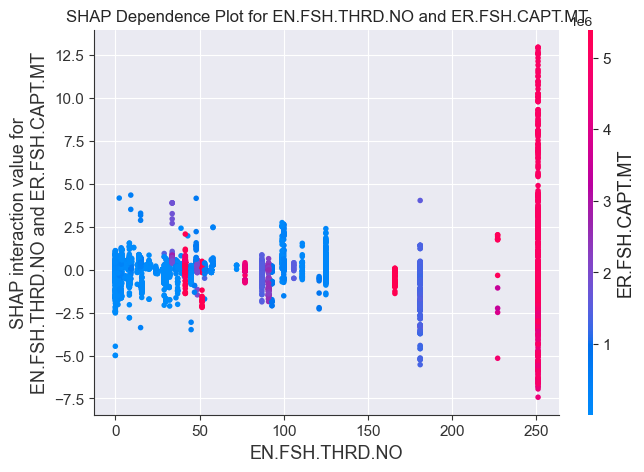

In [43]:
# Dependency plot
shap.dependence_plot(("EN.FSH.THRD.NO", "ER.FSH.CAPT.MT"), shap_interaction, X_val_trans_GLOB, show=False)
plt.title(f"SHAP Dependence Plot for EN.FSH.THRD.NO and ER.FSH.CAPT.MT")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

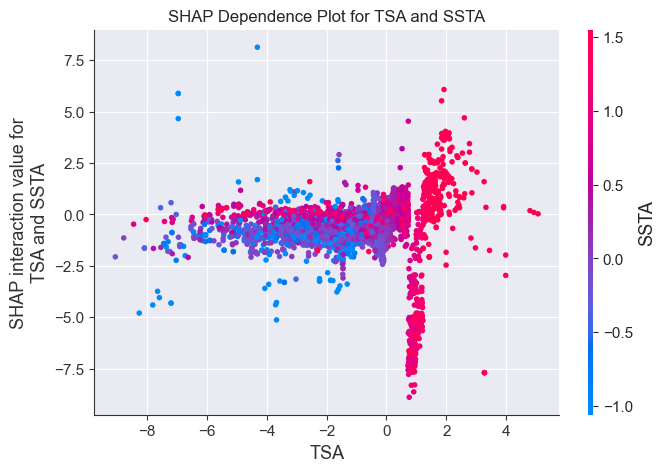

In [49]:
# Dependency plot
shap.dependence_plot(("TSA", "SSTA"), shap_interaction, X_val_trans_GLOB, show=False)
plt.title(f"SHAP Dependence Plot for TSA and SSTA")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

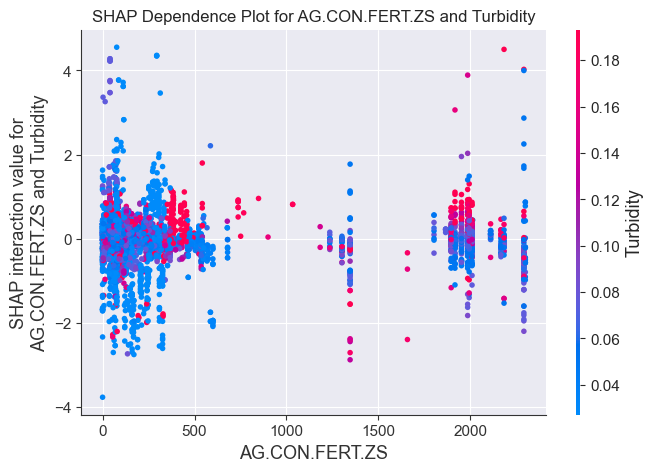

In [45]:
# Dependency plot
shap.dependence_plot(("AG.CON.FERT.ZS", "Turbidity"), shap_interaction, X_val_trans_GLOB, show=False)
plt.title(f"SHAP Dependence Plot for AG.CON.FERT.ZS and Turbidity")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

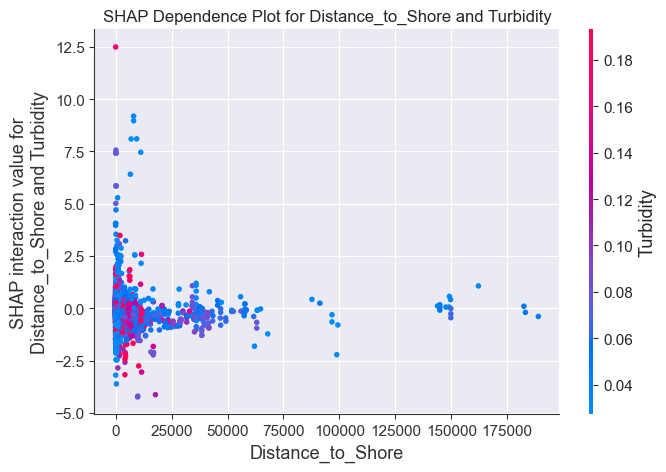

In [51]:
# Dependency plot
shap.dependence_plot(("Distance_to_Shore", "Turbidity"), shap_interaction, X_val_trans_GLOB, show=False)
plt.title(f"SHAP Dependence Plot for Distance_to_Shore and Turbidity")
#anno_text = f'Important Info'
#plt.annotate(anno_text, (0.5, -0.2), xycoords='axes fraction', fontsize=8, color='gray', ha='center')
plt.show()

# Results and Analysis

Insert analysis of SHAP Beeswarrm, Feature, Scatter & Dependency plots here 